In [1]:
# Import
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import os
import random
from shutil import copyfile

import cv2
import matplotlib.pyplot as plt

from ae_models import *

In [62]:
# Constants
HEIGHT = 64
WIDTH = 64
BATCH_SIZE = 10
SPLIT_RATIO = 0.9
TARGET_SIZE = (HEIGHT, WIDTH)

In [3]:
# Unzip file
import tarfile

filename = 'dataset/synthetic_sugarbeet_random_weeds'

# my_tar = tarfile.open(filename + '.tar.gz')
# my_tar.extractall('dataset')
# my_tar.close()

In [4]:
# Function to create all directories from a string path
def make_directory(fullpath):
    splitted_data = fullpath.split('/')
    
    new_dir = []
    current_dir = '.'
    
    for folder in splitted_data:           
        current_dir = current_dir + '/' + folder                
        if not os.path.isdir(current_dir + '/'):
            new_dir.append(current_dir)
            os.mkdir(current_dir)
    
    return new_dir

In [5]:
# Write a python function called split_data which takes
# a FOLDER_IMAGES directory containing the images
# a FOLDER_MASKS directory containing the masks
# a TARGET_FOLDER directory where the files will be copied to
# the TARGET_FOLDER directory will contain 2 subfolders train and test with the data splitted
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SPLIT SIZE is .9
# Then 90% of the images will be copied to the TARGET_FOLDER/train dir
# and 10% of the images will be copied to the TARGET_FOLDER/test dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
def split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, SPLIT_SIZE):

    TRAINING_FOLDER_NAME = TARGET_FOLDER + '/train/'
    TESTING_FOLDER_NAME = TARGET_FOLDER + '/test/'
    TRAINING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/train/images/img/'
    TRAINING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/train/masks/img/'
    TESTING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/test/images/img/'
    TESTING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/test/masks/img/'

    # Create directories
    make_directory(TRAINING_FOLDER_NAME_IMAGES)
    make_directory(TRAINING_FOLDER_NAME_MASKS)
    make_directory(TESTING_FOLDER_NAME_IMAGES)
    make_directory(TESTING_FOLDER_NAME_MASKS)
    
    # Remove all data in TRAINING and TESTING dir
    for i_file in os.listdir(TRAINING_FOLDER_NAME_IMAGES):
        os.remove(TRAINING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TRAINING_FOLDER_NAME_MASKS):
        os.remove(TRAINING_FOLDER_NAME_MASKS + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_IMAGES):
        os.remove(TESTING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_MASKS):
        os.remove(TESTING_FOLDER_NAME_MASKS + i_file)
    
    dataset = []
    
    # Check for z zero file length
    for i_file in os.listdir(FOLDER_IMAGES):
        data = i_file
        if (os.path.getsize(FOLDER_IMAGES + data) > 0):
            dataset.append(i_file)
        else:
            print('Skipped ' + i_file)
            print('Invalid file size! i.e Zero length.')
    
    # Number of files
    nb_files = len(dataset)
    nb_files_training = int(nb_files * SPLIT_SIZE)
    nb_files_testing = nb_files - nb_files_training
    
    # Suffle dataset
    shuffled_dataset = random.sample(dataset, len(dataset))
        
    # Copy files
    for i_num, i_file in enumerate(shuffled_dataset):
        if i_num < nb_files_training:
            new_path_images = TRAINING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TRAINING_FOLDER_NAME_MASKS + i_file
        else:
            new_path_images = TESTING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TESTING_FOLDER_NAME_MASKS + i_file
            
        copyfile(FOLDER_IMAGES + i_file, new_path_images)
        copyfile(FOLDER_MASKS + i_file, new_path_masks)
        
    return nb_files_training

In [6]:
# Split data
FOLDER_IMAGES = "dataset/synthetic_sugarbeet_random_weeds/rgb/"
FOLDER_MASKS = "dataset/synthetic_sugarbeet_random_weeds/gt/"
TARGET_FOLDER = "dataset/synthetic_sugarbeet_random_weeds/train_test/"

NB_TRAINED_IMAGES = split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, SPLIT_RATIO)
print('Number of trained images:', NB_TRAINED_IMAGES)

Number of trained images: 1126


In [7]:
# Understand how the mask is made
mask_path = "dataset/synthetic_sugarbeet_random_weeds/gt/"
list_masks = os.listdir(mask_path)

masks_layer1 = []
masks_layer2 = []
masks_layer3 = []
for i in range(5):
    current_mask = cv2.imread(mask_path + list_masks[i])
    masks_layer1 = np.concatenate([masks_layer1, current_mask[:,:,0].flatten()])
    masks_layer2 = np.concatenate([masks_layer1, current_mask[:,:,1].flatten()])
    masks_layer3 = np.concatenate([masks_layer1, current_mask[:,:,2].flatten()])
    
print(set(masks_layer1))
print(set(masks_layer2))
print(set(masks_layer3))

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}


In [8]:
# Plot masks
mask_path = "dataset/synthetic_sugarbeet_random_weeds/gt/"
list_masks = os.listdir(mask_path)

for i in range(3):
    current_mask = cv2.imread(mask_path + list_masks[i])
    current_mask = current_mask*100
    layers = np.concatenate((current_mask[:,:,0], current_mask[:,:,1], current_mask[:,:,2]), axis=1)
    
    if i > 0:
        images = np.concatenate((images, layers), axis=0)
    else:
        images = layers            

# Plot image
cv2.imshow('Example', images) 
cv2.waitKey(0)

-1

In [74]:
# Pre-processing of images and masks
def preprocessing_masks(mask):
    img = mask > 0
    img = tf.cast(img, tf.float32)
    return img    

def preprocessing_images(image):
    img = image.astype(np.float32)
    img = cv2.resize(image, (TARGET_SIZE[1], TARGET_SIZE[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.    
    return img

In [10]:
# Post processing of images and masks for visualization
def postprocessing_masks_rgb(mask, new_size=TARGET_SIZE):
    img = mask>0
    img = img * 255
    img = img.astype(np.uint8)
    img = cv2.resize(img, (new_size[1], new_size[0]))
    return img

def postprocessing_masks_prediction(mask, new_size=TARGET_SIZE):
    img = np.zeros(shape=(mask.shape[0], mask.shape[1], 3))
    img[:,:,0] = img[:,:,1] = img[:,:,2]= mask[:,:,0]
    img = img * 255
    img = img.astype(np.uint8)
    img = cv2.resize(img, (new_size[1], new_size[0]))
    return img

def postprocessing_images(image, new_size=TARGET_SIZE):
    img = cv2.resize(image, (new_size[1], new_size[0]))
    return img

In [11]:
# Function to plot an image with its mask
def plot_image_with_mask(image, mask):    
    mask_norm = postprocessing_masks_rgb(mask, image.shape)
        
    mixed_image = cv2.addWeighted(image, 0.5, mask_norm, 0.5, 0)      
    raw_images = np.concatenate((image, mask_norm), axis=1)
    example = np.concatenate((raw_images, mixed_image), axis=1)
    
    # Plot image
    cv2.imshow('Example', example) 
    cv2.waitKey(0)

In [12]:
list_files = os.listdir(TARGET_FOLDER + 'train/images/img/')
print('Number of images:', len(list_files))
IMG_ID = 0
print('Selected image:', IMG_ID)

example_image = cv2.imread(TARGET_FOLDER + 'train/images/img/' + list_files[IMG_ID])
example_mask = cv2.imread(TARGET_FOLDER + 'train/masks/img/' + list_files[IMG_ID])

print(np.max(example_image[:,:,0]))
print(np.max(example_image[:,:,1]))
print(np.max(example_image[:,:,2]))

plot_image_with_mask(example_image, example_mask)

Number of images: 1126
Selected image: 0
70
133
172


In [57]:
# Data augmentation (for train dataset)
SEED = 0

train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1)
train_image_generator = train_image_datagen.flow_from_directory(TARGET_FOLDER + 'train/images',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               color_mode='rgb',
                                                               class_mode=None,
                                                               seed=SEED)

train_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_masks,
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1)
train_mask_generator = train_mask_datagen.flow_from_directory(TARGET_FOLDER + 'train/masks/',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               color_mode='grayscale',
                                                               class_mode=None,
                                                               seed=SEED)

Found 1126 images belonging to 1 classes.
Found 1126 images belonging to 1 classes.


In [58]:
# Data augmentation (for validation dataset)
SEED = 1

val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_image_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/images',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

val_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_masks)
val_mask_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/masks/',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

Found 126 images belonging to 1 classes.
Found 126 images belonging to 1 classes.


In [59]:
# Create custom generator for training images and masks
def my_image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask, [None])
        
my_train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
my_val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

In [90]:
# Display one couple image/mask from generators
for (img, mask) in my_train_generator:
        
    # Image
    cur_image = img[0]*255
    cur_image = cur_image.astype(np.uint8)
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    
    # Mask    
    cur_mask = np.zeros(shape=cur_image.shape)
    cur_mask[:,:,0] = cur_mask[:,:,1] = cur_mask[:,:,2] = mask[0][:,:,0] * 255.
    
    # Create concatenation
    image_mask = np.concatenate((cur_image, cur_mask), axis=1)
    image_mask = image_mask.astype(np.uint8)

    # Plot image
    cv2.imshow('Example from generator', image_mask) 
    cv2.waitKey(0)

    break

In [64]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
n_classes = 1
dec_op = fcn8_decoder(convs, n_classes)

print(dec_op.shape)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

(None, 64, 64, 1)


In [65]:
# Compile your model here
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

steps = NB_TRAINED_IMAGES / BATCH_SIZE
steps = 5000 / BATCH_SIZE
print('Steps:', steps)

# Train your model here
history = model.fit(my_train_generator,
                    steps_per_epoch=steps,
                    epochs=5,
                    verbose=1,
                    validation_data=my_val_generator,
                    validation_steps=steps)

Steps: 500.0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.0 steps, validate for 500.0 steps
Epoch 1/5
500/500 [==============================] - 501s 1s/step - loss: 0.6862 - accuracy: 0.5289 - val_loss: 0.6835 - val_accuracy: 0.5263
Epoch 2/5
500/500 [==============================] - 465s 930ms/step - loss: 0.5702 - accuracy: 0.6507 - val_loss: 0.5173 - val_accuracy: 0.6722
Epoch 3/5
500/500 [==============================] - 473s 946ms/step - loss: 0.3116 - accuracy: 0.8641 - val_loss: 0.2747 - val_accuracy: 0.9043
Epoch 4/5
500/500 [==============================] - 466s 932ms/step - loss: 0.1682 - accuracy: 0.9549 - val_loss: 0.1935 - val_accuracy: 0.9334
Epoch 5/5
500/500 [==============================] - 465s 931ms/step - loss: 0.1211 - accuracy: 0.9655 - val_loss: 0.1418 - val_accuracy: 0.9387


In [79]:
# Plot one prediction
IMG_ID = 6
pathname = 'train/images/img/'
list_files = os.listdir(TARGET_FOLDER + pathname)

example_image = cv2.imread(TARGET_FOLDER + 'train/images/img/' + list_files[IMG_ID])
example_mask = cv2.imread(TARGET_FOLDER + 'train/masks/img/' + list_files[IMG_ID])

image_processed = preprocessing_images(example_image)
image_processed = tf.expand_dims(image_processed, axis=0)

prediction = model.predict(image_processed)
pred_image = np.array(tf.squeeze(prediction, axis=0))

image_example_gt = np.concatenate((postprocessing_images(example_image),
                                   postprocessing_masks_rgb(example_mask),
                                   postprocessing_masks_prediction(pred_image)), axis=1)
cv2.imshow('Example', image_example_gt) 
cv2.waitKey(0)

-1

Text(0.5, 1.0, 'Loss')

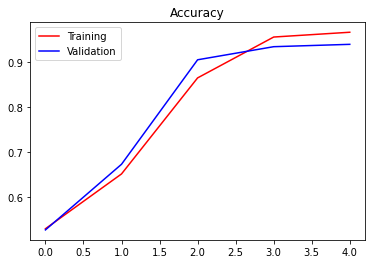

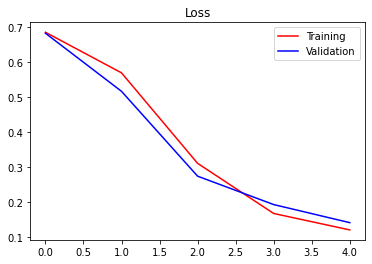

In [130]:
# PLOT LOSS AND ACCURACY
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.legend(["Training", "Validation"])
plt.title('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation"])
plt.title('Loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [80]:
# Save model
model.save("model.h5")

In [81]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [83]:
class_wise_iou, class_wise_dice_score = class_wise_metrics(postprocessing_masks_rgb(example_mask), postprocessing_masks_prediction(pred_image))
print(class_wise_iou)
print(class_wise_dice_score)

[0.4845549733991667]
[0.6527949211468906]


In [124]:
for (img, mask) in my_val_generator:
    
    average_iou = 0.
    average_dice = 0.
    count = 0.
    for cur_img, cur_mask in zip(img, mask):
        count += 1
        
        # Compute prediction
        tensor_img = np.expand_dims(cur_img, axis=0)
        result = model.predict(tensor_img)
        
        # Compute performance
        cls_wise_iou, cls_wise_dice_score = class_wise_metrics(cur_mask, postprocessing_masks_prediction(result[0]))        
        
        average_iou += cls_wise_iou[0]
        average_dice += cls_wise_dice_score[0]
    
    average_iou = average_iou / count
    average_dice = average_dice / count
    
    break

print('Average IoU:', average_iou*100)
print('Average Dice:', average_dice*100)

Average IoU: 45.1770484613233
Average Dice: 61.12187834253
